# Introduction

TensorFlow™ is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms using (CPUs, GPUs, TPUs (TEnsor Processing Units)), and from desktops to clusters of servers to mobile and edge devices [1].

Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains.

TensorFlow is an interface to express machine learning algorithms and provides an implementation for executing such algorithms. In this regard, TensoFlow is not a package/API that can be used to pass your training data and get a predictor/classifier/regression tool. Instead, it is a lower level library that provides features required to implement machine learning algorithms in an optimal way. Also, there are predefined implementations of algorithms that a user can use if the flexibility of designing the implementation is not desired. 

TensorFlow is designed to facilitate scaling your application by separating the language interface and the execution allowing the code to be executed as a prototype on your laptop or the final product on a cluster.

*Language Interface:*

    Python, C++, ...

*Execution Environment:*

    Execution master to choose Local CPU, GPU or a master node on a cluster

Source of the name TensorFlow: N dimensional arrays aka Tensors along with mathematical operations are the base of the computation graph executed by TensorFlow.


**References:**

http://TensorFlow.org

https://app.pluralsight.com

# Installation

The following factors can affect the installation:
    - OS
    - GPU (cuda enabaled) 
    - Environment (Direct, Virtual, Docer Container)
    - Python version (assumin that python is used for the programming language)
        Linux, MacOS --> 2.7, 3.3 or later
        windows --> 3.5 or later
    
**For graphic cards info:**

```shell
$ dxdiag
```
or use chrome:gpu on your chrome browser

**For python version:**

```python
import sys
sys.version
```

**Installation using pip:**

```shell
pip install --upgrade tensorflow -- Chose the cpu version
```

Note that on tensorflow.org you have the option to download the source file from github and config it on your machine.



In [1]:
import sys
sys.version

'3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]'

## Testing installation

In [2]:
import warnings
warnings.filterwarnings("ignore") # Avoid some deprecation warnings
import tensorflow as tf
print('TensorFlow version {}'.format(tf.__version__))
print(tf.__doc__)

TensorFlow version 1.12.0
Bring in all of the public TensorFlow interface into this module.


In [3]:
sess = tf.Session() # Starting a local session.

In [4]:
a = tf.constant(20)
b = tf.constant(50)
print('a*b = {}'.format(sess.run(a*b)))

a*b = 1000


In [5]:
a.eval(session=sess)

20

# First Example

A simple example of predictinh house proce based on as single variable/feature of house size.

In [6]:
import tensorflow as tf

import numpy as np
import pandas as pd
import math
import random
from matplotlib import pyplot as plt
from matplotlib import animation
import pygeostat as gs # http://www.ccgalberta.com/pygeostat/welcome.html

## Data preparation

In [7]:
num_house = 200
np.random.seed(69067)
house_size = np.random.randint(1000, 3500, num_house)
data_housing = pd.DataFrame(columns=['HouseSize'], data=house_size)

data_housing['HousePrice'] = data_housing['HouseSize'].apply(lambda size: size* 200 + np.random.randint(10000, 60000))

In [8]:
data_housing.head()

,HouseSize,HousePrice
0,2888,603358
1,3004,645019
2,1020,245554
3,2062,446094
4,2518,544830


### Visualize data

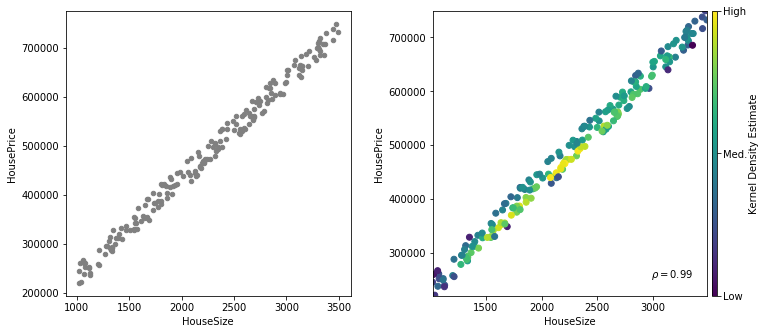

In [9]:
fig,ax = plt.subplots(1,2, figsize=(11,5))
# Simple scat plot
data_housing.plot(x='HouseSize', y='HousePrice', kind='scatter',ax=ax[0], color='gray')
# Scatter plot with bivariate PDF highlight
gs.scatplt(data_housing.HouseSize, data_housing.HousePrice, ax=ax[1], cbar=True)
fig.tight_layout(pad=2.0)

%%latext
The price was generated based on a simple equation:

$ Price = SizeFactor \times Size + PriceOffset $

### Standardization

In [10]:
size_mean = np.mean(data_housing['HouseSize'])
size_std = np.std(data_housing['HouseSize'])
data_housing['HouseSize_std'] = data_housing['HouseSize'].apply(lambda x: (x - size_mean)/ size_std )

price_mean = np.mean(data_housing['HousePrice'])
price_std = np.std(data_housing['HousePrice'])
data_housing['HousePrice_std'] = data_housing['HousePrice'].apply(lambda x: (x - price_mean)/ price_std)

data_housing.head()

,HouseSize,HousePrice,HouseSize_std,HousePrice_std
0,2888,603358,0.911765,0.834757
1,3004,645019,1.077531,1.128504
2,1020,245554,-1.757644,-1.688076
3,2062,446094,-0.268606,-0.274092
4,2518,544830,0.383027,0.422083


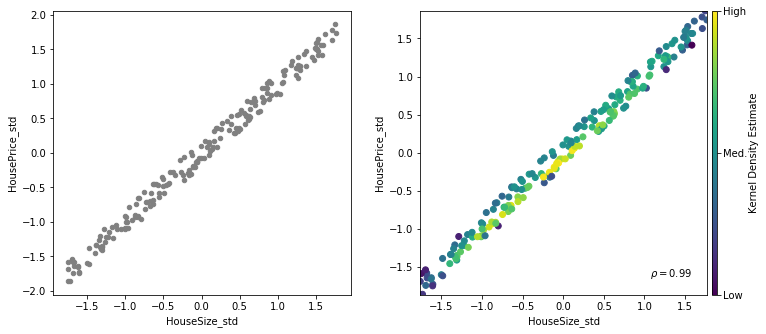

In [11]:
fig,ax = plt.subplots(1,2, figsize=(11,5))
# Simple scat plot
data_housing.plot(x='HouseSize_std', y='HousePrice_std', kind='scatter',ax=ax[0], color='gray')
# Scatter plot with bivariate PDF highlight
gs.scatplt(data_housing.HouseSize_std, data_housing.HousePrice_std, ax=ax[1], cbar=True)
fig.tight_layout(pad=2.0)

### Select test and train data

In [12]:
tarin_portion = 0.7
train_mask = np.random.rand(len(data_housing)) < tarin_portion
data_housing_train = data_housing[train_mask].reset_index(drop=True)
num_tarining_data = len(data_housing_train)
data_housing_test = data_housing[~train_mask].reset_index(drop=True)
print('Number of training data: {} \nNumber of test data: {}'.format(len(data_housing_train), len(data_housing_test)))

Number of training data: 139 
Number of test data: 61


In [13]:
# Inspect training data
data_housing_train.head()

,HouseSize,HousePrice,HouseSize_std,HousePrice_std
0,2888,603358,0.911765,0.834757
1,3004,645019,1.077531,1.128504
2,1020,245554,-1.757644,-1.688076
3,2062,446094,-0.268606,-0.274092
4,2518,544830,0.383027,0.422083


## Use tensor flow
Note about tensor types:

- Constant: Constant value that does not change
- Variable: Value adjusted in the computation graph of TensorFlow
- PlaceHodler: Used to pass data into the graph (e.g. from an external source)

Also, the following concepts:
- Model: A set of mathematical operations supported by tensor flow that defined the neural network part of the computation graph
- Cost function: The target function to optimize by calculation the error and modify the weight through back propagation steps
- Optimization algorithm

In [14]:
# DEfine the placeholders that get updated as our model gets optimized
tf_house_size = tf.placeholder(dtype='float', name='HouseSize')
tf_house_price =tf.placeholder(dtype='float', name='HousePrice')

In [15]:
# Define variables that get modified as we train our model based on the provided data
tf_size_factor = tf.Variable(np.random.randn(), name = 'SizeFactor')
tf_price_offset = tf.Variable(np.random.randn(), name = 'PriceOffset')

In [16]:
# Define the operation/model that needs to be trained to provide optimal result (minimum error based on the training data)
tf_price_predict = tf.add(tf.multiply(tf_size_factor, tf_house_size), tf_price_offset)

In [17]:
# Define a cost fucntion that can be used to tarin the model i.e. mean squer error
tf_cost = tf.reduce_sum(tf.pow(tf.subtract(tf_price_predict,tf_house_price),2))/num_tarining_data

In [18]:
learning_rate = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(tf_cost)

In [19]:
init = tf.global_variables_initializer()
dispaly_freq = 5
num_train_iterations = 50

size_factor_calc = []
price_offset_calc = []
training_cost = []

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        # This works becuase of the reduce sum over all data
        sess.run(optimizer, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        
#         # Alternatively, each training record may be passed separately (TensorFlow optimizer remembers)
#         for (x,Y) in zip(data_housing_train['HouseSize_std'], data_housing_train['HousePrice_std']): # Note that palce holders need to be fed
#             sess.run(optimizer, feed_dict={tf_house_size: x, tf_house_price: Y})
        
        # Get the cost function value
        c = sess.run(tf_cost, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        training_cost.append(c)
        # get the size factor and price offset st the current iteration
        size_factor_calc.append(sess.run(tf_size_factor))
        price_offset_calc.append(sess.run(tf_price_offset))
        
        if (iteration + 1)%dispaly_freq == 0:
            
            
            print('Iteration number: %03d'%(iteration+1), 'cost = {:.9f}'.format(training_cost[iteration]),\
                 'size factor =', size_factor_calc[iteration], 'price offset=', price_offset_calc[iteration])
            
    print('Optimization is done!')
    print('Final training cost = {:.5f}'.format(training_cost[-1]))
    print('Final size factor = ', size_factor_calc[-1])
    print('Final price offset = ', price_offset_calc[-1])

Iteration number: 005 cost = 0.335674226 size factor = 0.48411888 price offset= 0.20984949
Iteration number: 010 cost = 0.041418154 size factor = 0.8385502 price offset= 0.059047006
Iteration number: 015 cost = 0.013540602 size factor = 0.9478251 price offset= 0.013060032
Iteration number: 020 cost = 0.010899332 size factor = 0.9815206 price offset= -0.0009520473
Iteration number: 025 cost = 0.010649065 size factor = 0.9919124 price offset= -0.0052176025
Iteration number: 030 cost = 0.010625349 size factor = 0.99511784 price offset= -0.0065148068
Iteration number: 035 cost = 0.010623102 size factor = 0.9961068 price offset= -0.0069088666
Iteration number: 040 cost = 0.010622889 size factor = 0.99641186 price offset= -0.007028422
Iteration number: 045 cost = 0.010622868 size factor = 0.9965061 price offset= -0.0070646424
Iteration number: 050 cost = 0.010622867 size factor = 0.9965352 price offset= -0.007075592
Optimization is done!
Final training cost = 0.01062
Final size factor =  0.9

### Visualize gradient descent evolution

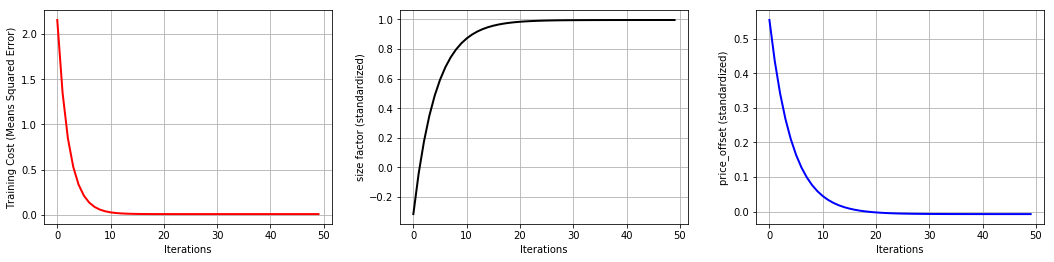

In [20]:
fig, minax = plt.subplots(1,3,figsize=(15,4))

ax = minax[0]
ax.plot(training_cost, c = 'r', lw =2)
ax.set_xlabel('Iterations'); ax.set_ylabel('Training Cost (Means Squared Error)')
ax.grid(True)

ax = minax[1]
ax.plot(size_factor_calc, c='k', lw=2)
ax.set_xlabel('Iterations'); ax.set_ylabel('size factor (standardized)')
ax.grid(True)

ax = minax[2]
ax.plot(price_offset_calc, c='b', lw=2)
ax.set_xlabel('Iterations'); ax.set_ylabel('price_offset (standardized)')
ax.grid(True)

fig.tight_layout(pad = 2.0)

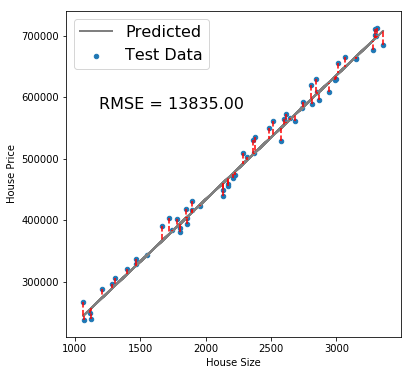

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

test_price_predicted = (size_factor_calc[-1]*data_housing_test.HouseSize_std + price_offset_calc[-1]) * price_std + price_mean

# Predicted Model
ax.plot(data_housing_test.HouseSize, test_price_predicted, c='gray', lw=2, label = 'Predicted')
# Actual test data
ax.scatter(data_housing_test.HouseSize, data_housing_test.HousePrice, s = 20, label = 'Test Data')

mean_squared_error = 0
for price_point, size_point, price_pred in zip(data_housing_test.HousePrice, data_housing_test.HouseSize, test_price_predicted):
    ax.plot([size_point, size_point], [price_point, price_pred], c='r', lw=1.5, ls ='--')
    mean_squared_error += (price_point - price_pred)**2

mean_squared_error = mean_squared_error/len(data_housing_test)
rmse = np.sqrt(mean_squared_error)

ax.text(0.1,.7, 'RMSE = {:.2f}'.format(rmse), transform = ax.transAxes, fontsize=16)

ax.set_xlabel('House Size'); ax.set_ylabel('House Price')
ax.legend(fontsize = 16)

## Comparison with Linear Regression

This example can be also solved by simple linear regression. As shown below, the result of gradient descent optimization and regression analysis are very close.

In [22]:
X = data_housing_test.HouseSize
y = data_housing_test.HousePrice
slope = np.cov(X,y)[0][1]/np.cov(X,y)[0][0] # Covariance(X,y)/Variance(X)
intercept = np.mean(y)-slope*np.mean(X) # mean(y) - slope * mean(X)

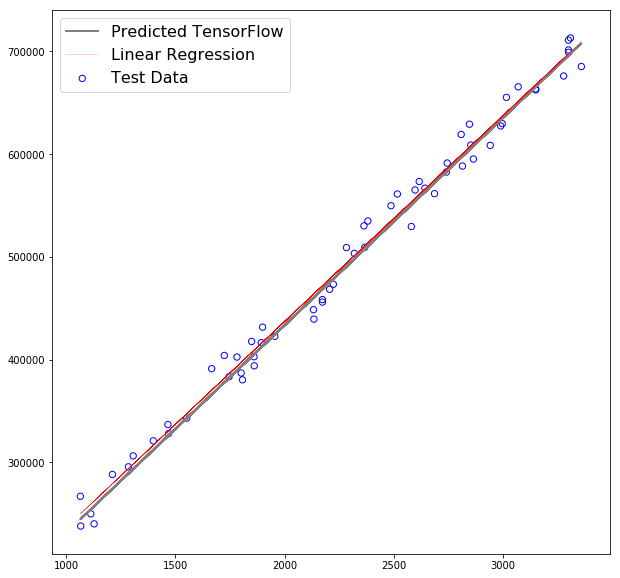

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# Predicted Model (TensorFlow)
ax.plot(data_housing_test.HouseSize, test_price_predicted, c='gray', lw=2, label = 'Predicted TensorFlow')
# Actual test data
ax.scatter(data_housing_test.HouseSize, data_housing_test.HousePrice, s = 40, label = 'Test Data', facecolors='none', edgecolors='b')
# Predicted linear regression
ax.plot(data_housing_test.HouseSize, slope*data_housing_test.HouseSize+intercept, c='red', lw=0.5, linestyle=':', label = 'Linear Regression')
ax.legend(fontsize = 16)

The root mean squared error of the optimized model for test data is shown in the plot above along with deviations of the actual price from the predicted one using the simple linear model. This is a simple linear regression example that was implemented using TensorFlow. Note that while variables rely on the initialization, placeholders are the tensors provided based on data (i.e. external source compared to the computation graph). You need to make sure the provided data result in tensors with dimensions that comply with the operation that you have added to your model.

# Tensor

Some introduction to tensor properties help to better understand how TensorFlow works. Note that mathematics is the base of any algorithm developed by humans. In case of tensors, linear algebra/multilinear algebra is of great significance.

Tensor may be defined as an n-dimensional array to represent data. For example 500 observations of 4 variable may be a tensor of 4 by 500 or the other way around.\

## Tensor Properties

Tensors in an operation need to shared compatible properties. 

### Rank

Dimensionality of a tensor.

| Rank        | Object           |
| ------------- |:-------------:|
| 0      | scalar |
| 1      | vector      |
| 2 | N by N matrix   |
| 3 | 3-Tensor(cube)   |
| n | n-Tensor(cube)   |

### Shape

It is closely related to the rank and also number of data in the tensor

example: 

| Rank        | Object           |  Example | Shape
| ------------- |:-------------:|:-------------:| :-------------:| 
| 0 |Scalar|s = 25 | []| 
| 2 |Matrix|m = [[1,2,3], [4,5,6]] | [2,3]| 
 
### Data Type

The following data types are supported by TensorFlow

- float32, float64
- int8, int16, int32, int64
- uint8, uint16
- string
- bool
- complex64, complex128
- qint8, qint16

qint short for Quantized values. The quantized data type is used to scale data/number to reduce size so it takes less bits. This helps to improve processing power of TensorFlow which is critical for scalability. Google has invested on special processing chips called TensoFlow Processing Units (TPUs) that utilize quantized values. 


### Tensor Info

TensorFlow provides the following methods to inspect a tensor:

- get_shape 
- reshape
- rank
- dtype
- cast

# Gradient Descent

Gradient descent is a popular optimization algorithm that works based on finding sequential steps/vectors in the multivariate space of features that provide the steepest reduction in the loss/cost function or steepest increase in the profit/gain function. The learning rate corresponds to the length of the vectors. The direction is determined based on derivative based on the features. 

![alt text](https://www.oreilly.com/library/view/learn-arcore-/9781788830409/assets/f3899ca3-835e-4d3e-8e7f-fd1c5a9044fb.png "Obtained from https://www.oreilly.com/")


## Animate Gradient Descent 

<IPython.core.display.Javascript object>


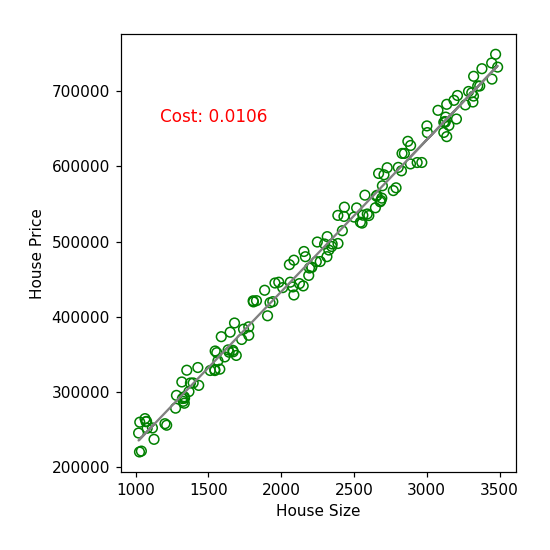

In [24]:
init = tf.global_variables_initializer()
dispaly_freq = 5
num_train_iterations = 50
%matplotlib notebook

with tf.Session() as sess:
    sess.run(init)
    
    size_factor_calc = []
    price_offset_calc = []
    training_cost = []
    
    
    for iteration in range(num_train_iterations):
        
        # This works becuase of the reduce sum over all data
        sess.run(optimizer, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        
        # Get the cost function value
        c = sess.run(tf_cost, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        training_cost.append(c)
        # get the size factor and price offset st the current iteration
        size_factor_calc.append(sess.run(tf_size_factor))
        price_offset_calc.append(sess.run(tf_price_offset))

    
    fig, ax = plt.subplots(1,1,figsize=(5,5))

    
    # Actual tarining data
    ax.scatter(data_housing_train.HouseSize, data_housing_train.HousePrice, s = 40, facecolors='none', edgecolors='g', label = 'Test Data')
    ax.set_xlabel('House Size')
    ax.set_ylabel('House Price')
    
    line, = ax.plot([],[], c='gray') 
    time_text = ax.text(.1, .8, '', fontsize=11, transform = ax.transAxes, color='r')
    fig.tight_layout(pad = 2.0)
    
    def update(i):
        test_price_predicted = (size_factor_calc[i]*data_housing_train.HouseSize_std + price_offset_calc[i]) * price_std + price_mean
        line.set_xdata(data_housing_train.HouseSize)
        line.set_ydata(test_price_predicted)
        time_text.set_text('Cost: {:.4f}'.format(training_cost[i]))
        return line, time_text,
    
    
    def initAnim():
        test_price_predicted = (size_factor_calc[0]*data_housing_train.HouseSize_std + price_offset_calc[0]) * price_std + price_mean
        line.set_ydata(test_price_predicted)
        line.set_xdata(data_housing_train.HouseSize)
        return line,
    
    anim = animation.FuncAnimation(fig, update, frames=num_train_iterations, init_func=initAnim, interval=200, blit=True)

# MNIST example

A data set containing 28 by 28 images of handwritten numbers from 0 to 9.

## Simple Neural Network

A simple network with one layer that maps the image pixels into the output classification categories (i.e. classes).

In [25]:
import tensorflow as tf
import random
import warnings
warnings.filterwarnings("ignore")
from toolbox.utilities import image_plot, transform_label, flatten_images, mnist_weight_check, mnist_result_anim
import numpy as np

The input data from TensorFlow's tutorial was not used as it has a deprecation warning. Instead, keras datasets was used to get the mnist data set. The main difference is that the image is not flatten and the labels are not classified by an array with max probability i.e. one_hot.

In [26]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Check an example image from the training set

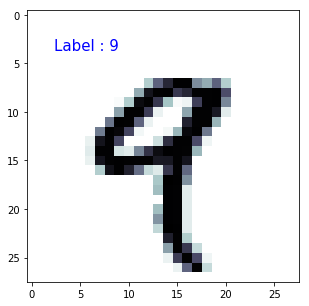

In [27]:
%matplotlib inline
image_plot(x_train[4], y_train[4])

### Transformations

In [28]:
y_train[0]

5

In [29]:
y_train, y_test = transform_label(y_train), transform_label(y_test)

In [30]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [31]:
x_train.shape

(60000, 28, 28)

In [32]:
x_train, x_test = flatten_images(x_train), flatten_images(x_test)

In [33]:
x_train.shape

(60000, 784)

### Define the Computation Graph

#### Define a helper function for summary reports in TensorBoard

In [34]:
def variable_summary(var):
    with tf.name_scope('Summary'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('Mean', mean)
        std = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('Std', std)
        
        tf.summary.scalar('Min', tf.reduce_min(var))
        tf.summary.scalar('Max', tf.reduce_max(var))
        tf.summary.histogram('HistoGram', var)

In [35]:
tf.reset_default_graph()

#### Define the mode

In [36]:
with tf.name_scope(name='InputLayer'):
    # plcae holder for the input which is a 28 by 28 image data
    x = tf.placeholder(tf.float32, shape=[None,784], name='Image')
    #place holder for predcicted output
    y = tf.placeholder(tf.float32, shape=[None,10], name = 'Classes')

# Weights and bias for the only layer of the model
with tf.name_scope('Weights'):
    w = tf.Variable(tf.zeros([784,10]), name='PixelWeights')
    variable_summary(w)
with tf.name_scope('Biases'):
    b = tf.Variable(tf.zeros([10]), name= 'PixelBiases')
    variable_summary(b)

with tf.name_scope('SimpleLayer'):
    layer1 = tf.matmul(x,w) + b

    
# Define model (make sure that the tensor rank an shape comply with the operation)
with tf.name_scope('Output'):
    y_p = tf.nn.softmax(layer1, name='Classes') # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)

# Define the lost that is cross_entropy
with tf.name_scope('CrossEntropy'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=layer1), name='SoftMaxCrossEntropy')
    # Note: soft max is implmeneted so, logits should be layer1 although using y_p would work too

learning_rate = 0.5
with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate, name='GDO').minimize(cross_entropy)

### Define the performance measure

In [37]:
with tf.name_scope(name='Accuracy'):
    correct = tf.equal(tf.argmax(y_p,1), tf.argmax(y,1), name='ArgMaxTransform')
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'AccuracyCalculation')

### Run the model

Note that the initial guess (i.e. zeros or random normal) can significantly affect the performance of the model and depending on the type of optimization algorithm, it may get the model trapped in local optimal solutions for weights and biases.

In [38]:
import shutil
from datetime import datetime

# Log path for tensor board
log_path = r'./tensorboard_log/{}'.format(datetime.now().strftime('%Y%m%d-%H%M%S')) # Log path for tensor board 
try:
    shutil.rmtree(log_path)
except:
    pass

print('Use the following command line to check the tensor board web service:\n\t tensorboard --logdir={}'.format(log_path))

Use the following command line to check the tensor board web service:
	 tensorboard --logdir=./tensorboard_log/20190316-145858


In [39]:
batch_size = 200
batch_list = [ i for i in range(0,len(x_train),batch_size)] # Break training data into batches
nump_epoch = 20
weight_repo = [] # Get all the weights


# Merging summary reports for the computation graph
all_summary = tf.summary.merge_all()
    
with tf.Session() as sess:
    tb_writer = tf.summary.FileWriter(logdir = log_path, graph=sess.graph, session=sess)
    
    sess.run(tf.global_variables_initializer()) # Session initilization
    
    
    for epoch in range(nump_epoch):
        for i in range(len(batch_list)-1):
            start_index = batch_list[i]
            end_index = batch_list[i+1]
            x_batch = x_train[start_index:end_index]
            y_batch = y_train[start_index:end_index]
            _, summary =sess.run([optimizer, all_summary], feed_dict={x: x_batch, y: y_batch})

        cost = sess.run(cross_entropy, feed_dict={x: x_batch, y:y_batch})
        
        accuracy_train = sess.run(accuracy, feed_dict={x: x_train, y:y_train})*100
        accuracy_test = sess.run(accuracy, feed_dict={x: x_test, y:y_test})*100
        print('Epoch: {}, Accuracy_train: %{:.2f}, Accuracy_test: %{:.2f}, Cost: {:.3f}'.format(epoch+1,
                                                                                                accuracy_train,
                                                                                                accuracy_test,
                                                                                                cost),end='')
        print('\r', end='')
        tb_writer.add_summary(summary, epoch)
        weight_repo.append(sess.run(w, feed_dict={x: x_batch, y:y_batch}))
    
    prediction = sess.run(y_p, feed_dict = {x: x_test, y: y_test})

### Visualize the final weights

Note that weights that connect all the pixels into one output neuron corresponds to the class that the neuron represents. As can be seen below, the first neuron that classifies zero, assigns more weights to the pixels that form the number 0 and so on.

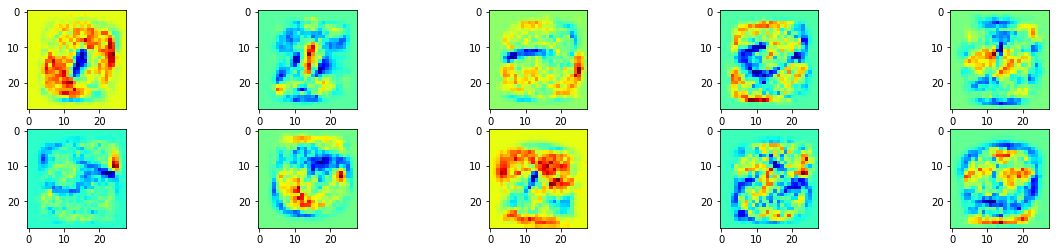

In [40]:
%matplotlib inline
mnist_weight_check(weight_repo[-1], shape=[28,28], cmap='jet')

### Visualize the prediction 

<IPython.core.display.Javascript object>


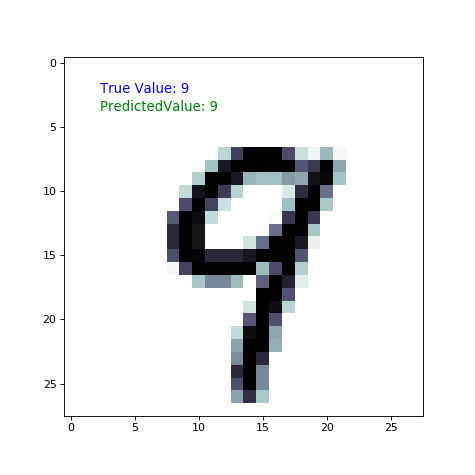

In [42]:
%matplotlib notebook

mnist_result_anim(x_test, y_test, prediction)


## Using keras
 
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. For more information, visit Keras.io. Currently, keras is a part of TensorFlow distribution so no need to install it separately.

### Deep Learning

In [43]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Normalize data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Note: no need to transform the labels to one-hot format. Keras will do that for you
model = tf.keras.models.Sequential()

# Input layer for the firsrt layer the input shape is required
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

# Two hiddedn layer. Keras figures out the input shape based on the previous layer
model.add(tf.keras.layers.Dense(units = 128, activation=tf.nn.relu)) # Rectified linear
model.add(tf.keras.layers.Dense(units = 128, activation=tf.nn.relu)) 

# Output layer
model.add(tf.keras.layers.Dense(units = 10, activation=tf.nn.softmax)) # output layer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=100, validation_data=(x_test, y_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 31us/step - loss: 0.3515 - acc: 0.9036 - val_loss: 0.1696 - val_acc: 0.9481
Epoch 2/4
60000/60000 [==============================] - 2s 28us/step - loss: 0.1347 - acc: 0.9595 - val_loss: 0.1185 - val_acc: 0.9633
Epoch 3/4
60000/60000 [==============================] - 2s 30us/step - loss: 0.0917 - acc: 0.9718 - val_loss: 0.1024 - val_acc: 0.9703
Epoch 4/4
60000/60000 [==============================] - 2s 28us/step - loss: 0.0677 - acc: 0.9794 - val_loss: 0.0858 - val_acc: 0.9744


#### Get the prediction

In [44]:
prediction = model.predict(x_test)

#### Visualize the predictions

<IPython.core.display.Javascript object>


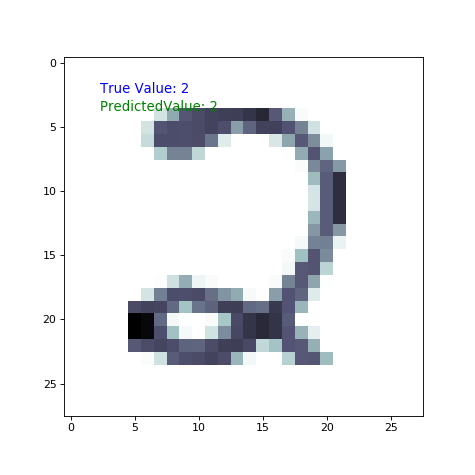

In [46]:
%matplotlib notebook
mnist_result_anim(x_test,y_test, prediction)
